In [27]:
import timeit
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import log_loss

import nltk
import re
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt


In [5]:
file = './data_cleaned.csv'
data = pd.read_csv(file)

In [6]:
data.head()

,Unnamed: 0,advertiser,industry,job_category,job_description,job_title,job_type,link,location,posting_date,search_word,sub_location,salary_cleaned,job_categorised,industry_categorised
0,0,Ambition Technology,Information & Communication Technology,Engineering - Software,"Our client, a Major Australian University are ...",Senior Data Engineer,Full Time,https://www.seek.com.au/job/39024106?type=stan...,Brisbane,15 May 2019,data scientist,CBD & Inner Suburbs,120000.0,seinor data engineer,technology
1,1,Randstad - Technologies,Information & Communication Technology,Database Development & Administration,The Data Engineer (Cloud/Data Lake) will play ...,Data Engineer - Cloud / Data Lake,Full Time,https://www.seek.com.au/job/39015517?type=stan...,Brisbane,14 May 2019,data scientist,CBD & Inner Suburbs,111526.0,data engineer,technology
2,2,PRA,Information & Communication Technology,Consultants,Brisbane CBD location - Permanent full time ro...,Data Engineer,Full Time,https://www.seek.com.au/job/38998989?type=stan...,Brisbane,11 May 2019,data scientist,CBD & Inner Suburbs,111526.0,data engineer,technology
3,3,Synergy Placements,Information & Communication Technology,Developers/Programmers,Contract role Large QLD organisation Brisbane...,Data Engineer Brisbane,Contract/Temp,https://www.seek.com.au/job/38957267?type=stan...,Brisbane,7 May 2019,data scientist,CBD & Inner Suburbs,208000.0,data engineer,technology
4,4,GRIT Talent Consulting,Information & Communication Technology,Database Development & Administration,We are seeking an experienced Data Engineer fo...,Data Engineer,Contract/Temp,https://www.seek.com.au/job/38943938?type=stan...,Brisbane,3 May 2019,data scientist,NaN,208000.0,data engineer,technology


In [7]:
data.drop(['Unnamed: 0','link','search_word'],axis=1,inplace=True)

## Creating X and y for modelling

In [8]:
for n in ['industry_categorised','job_categorised','location','job_type']:
    new_dummy = pd.get_dummies(data[n],prefix=n, prefix_sep='_',drop_first=True)
    data = pd.concat([data,new_dummy],axis=1)

In [9]:
stop_words = set(stopwords.words("english"))
new_words = ["data","salary","id","apply","cv","resume",'b','c','e','f','g','h','j','k','l',
             'n','p','q','t','u','v','w','x','z','au','australia','australian','year','world','sydney',
             'melbourne','brisbane','work','working','please','click','role','sound','high',
             'include','join','format','candidate','new','zealand','month','paced','service','previous','ability',
             'based','using','key','best','within','opportunity','cover','letter','skill','confidential','bi',
             'analyst','scientist','engineer','business','intelligence']
stop_words = stop_words.union(new_words)

vect = TfidfVectorizer(max_features=100,min_df=5,max_df=0.7,stop_words=stop_words,ngram_range=(1,1))
stem = PorterStemmer() #stem.stem
lem = WordNetLemmatizer() #lem.lemmatize

def clean_words(row):
    row = row.lower()    
    row = re.sub('[^a-zA-Z]',' ',row)
    row = nltk.word_tokenize(row)
    row = [lem.lemmatize(word) for word in row if not word in stop_words]
#     row = [stem.stem(word)for word in row]
    row = " ".join(row)
    return row

def create_tfidf(column):
    temp_list = []
    for i in data[column]:
        temp_list.append(clean_words(i))
    return pd.DataFrame(vect.fit_transform(temp_list).toarray(), columns=vect.get_feature_names())




In [10]:
data['descript_cleaned'] = data['job_description'].apply(clean_words)


In [11]:
tfidf_df = create_tfidf('descript_cleaned')
tfidf_df

,across,also,analysis,analytical,analytics,application,aws,background,big,build,...,support,system,technical,technology,time,tool,understanding,value,well,would
0,0.273084,0.000000,0.000000,0.000000,0.128914,0.000000,0.000000,0.179513,0.000000,0.172150,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.143279,0.168730,0.000000,0.000000,0.000000
1,0.248615,0.000000,0.127816,0.000000,0.312969,0.044022,0.000000,0.108952,0.000000,0.000000,...,0.085728,0.092670,0.082226,0.039416,0.054624,0.130441,0.051204,0.108659,0.000000,0.000000
2,0.085478,0.000000,0.000000,0.000000,0.322813,0.000000,0.121037,0.000000,0.231034,0.107770,...,0.000000,0.000000,0.000000,0.243935,0.112683,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.270675,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.260067,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.191903,0.000000,0.000000,0.000000,0.000000,0.212068,0.000000,0.194897,0.223217
6,0.093127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.312414,0.092401,0.000000,0.000000,0.000000,0.000000,0.122106,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.272632,0.126566,0.130100,0.000000,...,0.000000,0.107652,0.000000,0.091576,0.000000,0.202038,0.000000,0.000000,0.000000,0.125218
8,0.085388,0.000000,0.087798,0.000000,0.000000,0.090718,0.120909,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.169445,0.081226,0.112565,0.000000,0.105518,0.000000,0.000000,0.000000
9,0.188903,0.244410,0.064745,0.000000,0.178350,0.000000,0.267485,0.000000,0.255287,0.000000,...,0.000000,0.000000,0.124953,0.299491,0.000000,0.000000,0.000000,0.082561,0.000000,0.000000


In [12]:
# disregarding senior or not - try categorise senior or not seperately.
def job_dummify(x):
    if x =='academic':
        return 1
    elif x=='business intelligence':
        return 2
    elif x=='data analyst':
        return 3
    elif x=='data engineer':
        return 4
    elif x=='data scientist':
        return 5
    elif x=='seinor academic':
        return 1
    elif x=='seinor business intelligence':
        return 2
    elif x=='seinor data analyst':
        return 3
    elif x=='seinor data engineer':
        return 4
    else:
        return 5
y = data.job_categorised.apply(job_dummify)

In [13]:
# X = pd.concat([tfidf_df,data[['location_Melbourne','location_Sydney',
#                              'job_type_Contract/Temp', 'job_type_Full Time',
#                              'industry_categorised_other','industry_categorised_technology']]]
#               ,axis=1)

X_train, X_test, y_train, y_test = train_test_split(tfidf_df,y, train_size = 0.8, random_state=42)

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Getting Keywords for each Category

In [14]:
# merging vectors back to original dataframe for referencing (not neccessary)
data2 = pd.concat([data,tfidf_df],axis=1)

In [15]:
# filtering for data scientist roles only
data_ds = data2[(data2['job_categorised']=="data scientist")|(data2['job_categorised']=="senior data scientist")]

In [16]:
# Then sortying by score to find the top 10 scoring words for data science. This is repeated for other job categories.
test_df = pd.DataFrame()
word=[]
score=[]
for i in data_ds.iloc[:,34:]:
    word.append(i)
    score.append(data_ds[i].mean())

test_df['word'] = word
test_df['score'] = score
test_df['score'] = test_df['score'].apply(lambda x: float(x))
test_df.sort_values('score',ascending=False,inplace=True)
print(test_df.head(10))

         word     score
75    science  0.201313
43   learning  0.162130
47    machine  0.135604
52      model  0.110205
15   customer  0.100590
7      client  0.092650
67     python  0.087453
82     strong  0.079776
53  modelling  0.077424
38    insight  0.076979


In [17]:
mask = np.array(Image.open('./DS.png'))

In [18]:
def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', stopwords=STOPWORDS, mask=mask).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [19]:
words = list(test_df['word'].head(30))
print(words)
words = ' '.join(words)

['science', 'learning', 'machine', 'model', 'customer', 'client', 'python', 'strong', 'modelling', 'insight', 'solution', 'product', 'research', 'development', 'financial', 'stakeholder', 'technical', 'leading', 'tool', 'technology', 'large', 'looking', 'background', 'information', 'project', 'knowledge', 'well', 'environment', 'etc', 'problem']


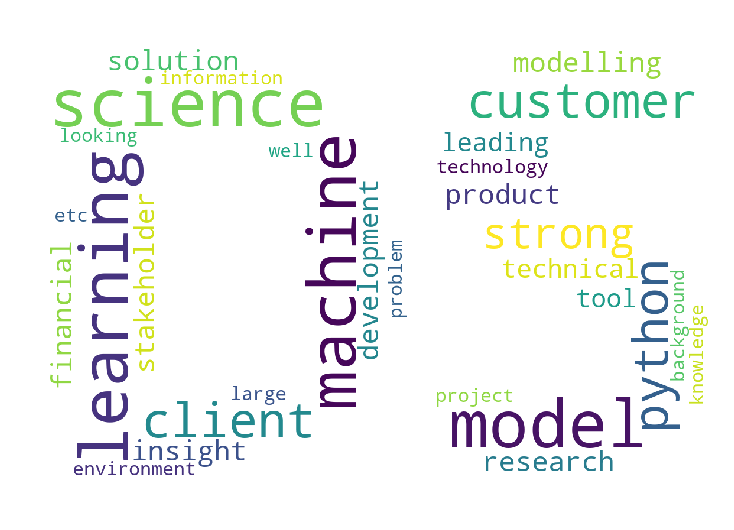

In [17]:
generate_wordcloud(words, mask) 

           word     score
2           big  0.124755
87   technology  0.109660
8         cloud  0.108960
0           aws  0.102871
23  development  0.092485
79     solution  0.090935
78     software  0.088954
7        client  0.088315
86    technical  0.082539
19       design  0.081022


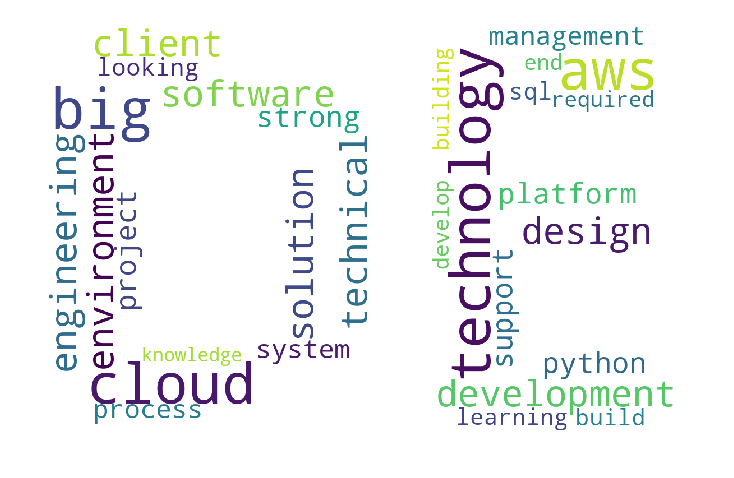

In [18]:
data_de = data2[(data2['job_categorised']=="data engineer")|(data2['job_categorised']=="senior data engineer")]

test_df = pd.DataFrame()
word=[]
score=[]
for i in data_de.iloc[:,34:]:
    word.append(i)
    score.append(data_de[i].mean())

test_df['word'] = word
test_df['score'] = score
test_df['score'] = test_df['score'].apply(lambda x: float(x))
test_df.sort_values('score',ascending=False,inplace=True)
print(test_df.head(10))
mask = np.array(Image.open('./DE.png'))

words = list(test_df['word'].head(30))
words = ' '.join(words)

generate_wordcloud(words, mask) 

           word     score
70    reporting  0.103298
49   management  0.098891
7        client  0.089897
80          sql  0.078694
69       report  0.074223
81  stakeholder  0.074169
65      project  0.070333
85       system  0.069563
37  information  0.069314
38      insight  0.067941


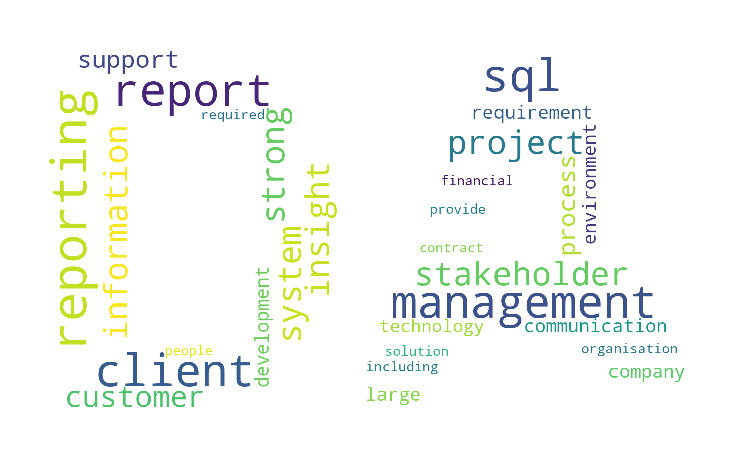

In [19]:
data_da = data2[(data2['job_categorised']=="data analyst")|(data2['job_categorised']=="senior data analyst")]
test_df = pd.DataFrame()
word=[]
score=[]
for i in data_da.iloc[:,34:]:
    word.append(i)
    score.append(data_da[i].mean())

test_df['word'] = word
test_df['score'] = score
test_df['score'] = test_df['score'].apply(lambda x: float(x))
test_df.sort_values('score',ascending=False,inplace=True)
print(test_df.head(10))
mask = np.array(Image.open('./DA.png'))

words = list(test_df['word'].head(30))
words = ' '.join(words)

generate_wordcloud(words, mask) 

           word     score
73     research  0.653090
43     learning  0.296503
47      machine  0.271996
61     position  0.162838
37  information  0.101385
44        level  0.101339
52        model  0.100492
75      science  0.088156
88         time  0.087219
41        large  0.080662


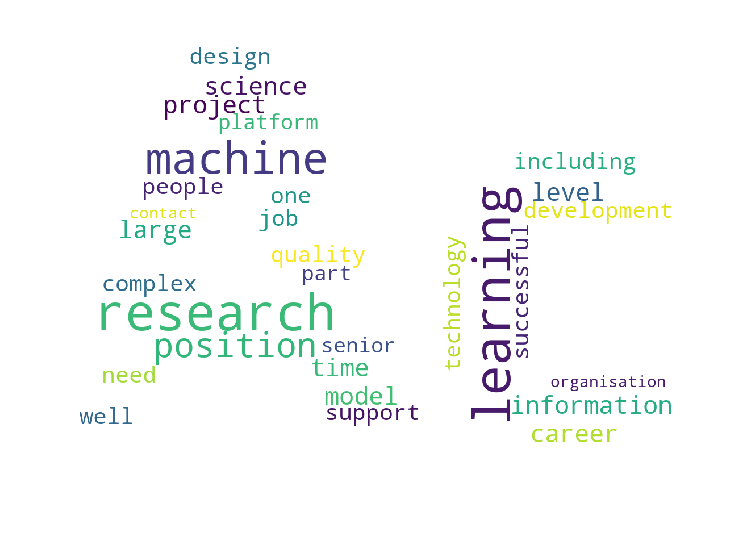

In [20]:
data_ac = data2[(data2['job_categorised']=="academic")|(data2['job_categorised']=="senior academic")]
test_df = pd.DataFrame()
word=[]
score=[]
for i in data_ac.iloc[:,34:]:
    word.append(i)
    score.append(data_ac[i].mean())

test_df['word'] = word
test_df['score'] = score
test_df['score'] = test_df['score'].apply(lambda x: float(x))
test_df.sort_values('score',ascending=False,inplace=True)
print(test_df.head(10))
mask = np.array(Image.open('./Ac.png'))

words = list(test_df['word'].head(30))
words = ' '.join(words)

generate_wordcloud(words, mask) 

           word     score
21    developer  0.113435
79     solution  0.112463
23  development  0.110290
19       design  0.102280
80          sql  0.094410
69       report  0.093352
65      project  0.088825
11      company  0.088336
7        client  0.085233
70    reporting  0.084389


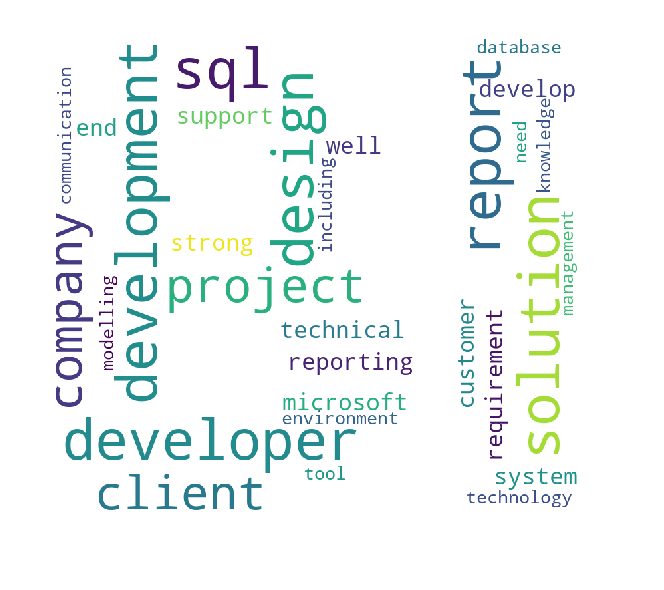

In [21]:
data_bi = data2[(data2['job_categorised']=="business intelligence")|(data2['job_categorised']=="senior business intelligence")]
test_df = pd.DataFrame()
word=[]
score=[]
for i in data_bi.iloc[:,34:]:
    word.append(i)
    score.append(data_bi[i].mean())

test_df['word'] = word
test_df['score'] = score
test_df['score'] = test_df['score'].apply(lambda x: float(x))
test_df.sort_values('score',ascending=False,inplace=True)
print(test_df.head(10))
mask = np.array(Image.open('./BI.png'))

words = list(test_df['word'].head(30))
words = ' '.join(words)

generate_wordcloud(words, mask) 

## Logistic Regression

Trying to predict job category based on TFIDF Vectors. Starting with Logistic Regression.

In [20]:
y_train.value_counts()

3    198
4    119
2    107
5     91
1      6
Name: job_categorised, dtype: int64

In [21]:
lr = LogisticRegression()
scores = cross_val_score(lr,X_train,y_train,cv=10,n_jobs=3)
lr.fit(X_train,y_train)

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
#also trying to understand how long it takes to train the model.
%timeit lr.fit(X_train,y_train)

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

12.9 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class 

In [22]:
baseline = 257/652

accuraccy_score_train = scores.mean()

accuraccy_score_test = lr.score(X_test,y_test)

y_pred = lr.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = lr.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuraccy score - train: ",accuraccy_score_train)
print("accuraccy score - test: ",accuraccy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

baseline:  0.3941717791411043
-------------------------------
r squared score - train:  0.6642787973438045
r squared score - test:  0.6870229007633588
-------------------------------
log loss score - train:  0.8182827314439728
log loss score - test:  0.8614030233398134


## Logistic Regression CV

In [30]:
lr_ridge = LogisticRegressionCV(penalty='l2',Cs=200,cv=10,n_jobs=3)
lr_ridge.fit(X_train,y_train)

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


LogisticRegressionCV(Cs=200, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=3, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [31]:
%timeit lr_ridge.fit(X_train,y_train)

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_gr

37.1 s ± 2.78 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
accuraccy_score_train = lr_ridge.score(X_train,y_train)

accuraccy_score_test = lr_ridge.score(X_test,y_test)

y_pred = lr_ridge.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = lr_ridge.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuraccy score - train: ",accuraccy_score_train)
print("accuraccy score - test: ",accuraccy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

baseline:  0.3941717791411043
-------------------------------
r squared score - train:  0.7677543186180422
r squared score - test:  0.7022900763358778
-------------------------------
log loss score - train:  0.6354628641445661
log loss score - test:  0.725577551262681


In [84]:
yhat = lr_ridge.predict(X_test)
conmat = np.array(confusion_matrix(y_test,yhat, labels=[1,2,3,4,5]))
confusion = pd.DataFrame(conmat, index=['is_academic', 'is_business_intelligence', 'is_data_analyst', 'is_data_engineer', 'is_data_scientist'],
                         columns=['predicted_academic','predicted_business_intelligence','predicted_data_analyst','predicted_data_engineer','predicted_data_scientist'])

confusion

,predicted_academic,predicted_business_intelligence,predicted_data_analyst,predicted_data_engineer,predicted_data_scientist
is_academic,1,0,1,0,1
is_business_intelligence,0,10,6,1,1
is_data_analyst,0,9,45,4,1
is_data_engineer,0,2,9,21,1
is_data_scientist,0,0,2,1,15


In [ ]:
    if x =='academic':
        return 1
    elif x=='business intelligence':
        return 2
    elif x=='data analyst':
        return 3
    elif x=='data engineer':
        return 4
    elif x=='data scientist':
        return 5

In [27]:
lr_lasso = LogisticRegressionCV(penalty='l1',solver='liblinear',Cs=20,cv=20,n_jobs=3)
lr_lasso.fit(X_train,y_train)

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=20.
  % (min_groups, self.n_splits)), Warning)


LogisticRegressionCV(Cs=20, class_weight=None, cv=20, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=3, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [28]:
r_squared_score_train = lr_lasso.score(X_train,y_train)

r_squared_score_test = lr_lasso.score(X_test,y_test)

y_pred = lr_lasso.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = lr_lasso.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("r squared score - train: ",r_squared_score_train)
print("r squared score - test: ",r_squared_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

baseline:  0.3941717791411043
-------------------------------
r squared score - train:  0.746641074856046
r squared score - test:  0.6793893129770993
-------------------------------
log loss score - train:  0.7135235367541882
log loss score - test:  0.8048630821433926


## SVM

In [32]:
parameters = {'C':[0.001,0.25,0.5,0.75,1,10],
              'kernel':['linear','rbf'],
              'gamma':['auto','scale',0.001,0.01,0.1,1,2,3],
              'decision_function_shape':['ovo','ovr']}

svm = SVC(probability=True,random_state=42)
grid_search = GridSearchCV(svm,param_grid=parameters,cv=5,n_jobs=3)
grid_search.fit(X_train,y_train)

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'C': [0.001, 0.25, 0.5, 0.75, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale', 0.001, 0.01, 0.1, 1, 2, 3], 'decision_function_shape': ['ovo', 'ovr']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
grid_search.best_params_

{'C': 0.5,
 'decision_function_shape': 'ovo',
 'gamma': 'auto',
 'kernel': 'linear'}

In [36]:
%timeit SVC(C=0.5,decision_function_shape='ovo',gamma='auto',kernel='linear').fit(X_train,y_train)

54.2 ms ± 4.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
accuraccy_score_train = grid_search.score(X_train,y_train)

accuraccy_score_test = grid_search.score(X_test,y_test)

y_pred = grid_search.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = grid_search.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuraccy score - train: ",accuraccy_score_train)
print("accuraccy score - test: ",accuraccy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

baseline:  0.3941717791411043
-------------------------------
accuraccy score - train:  0.727447216890595
accuraccy score - test:  0.6564885496183206
-------------------------------
log loss score - train:  0.6728563125306137
log loss score - test:  0.7778876716602355


## Random Forest

In [37]:
forest = RandomForestClassifier(max_depth=5,max_leaf_nodes=15)
forest.fit(X_train,y_train)

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=15,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
%timeit forest.fit(X_train,y_train)

22.4 ms ± 392 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
accuraccy_score_train = forest.score(X_train,y_train)

accuraccy_score_test = forest.score(X_test,y_test)

y_pred = forest.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = forest.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuraccy score - train: ",accuraccy_score_train)
print("accuraccy score - test: ",accuraccy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

baseline:  0.3941717791411043
-------------------------------
accuraccy score - train:  0.7024952015355086
accuraccy score - test:  0.6717557251908397
-------------------------------
log loss score - train:  0.8512503169012554
log loss score - test:  0.9932518275046978


In [40]:
forest.score(X_train,y_train)

0.7024952015355086

## XGBoost

In [78]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth= 9,eta= 0.1,verbosity= 1,objective= 'multi:softprob',num_class= 5,reg_lambda=700)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train,y_train,eval_metric=['merror','mlogloss'],eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.324376	validation_0-mlogloss:1.59978	validation_1-merror:0.458015	validation_1-mlogloss:1.60135
[1]	validation_0-merror:0.309021	validation_0-mlogloss:1.59026	validation_1-merror:0.458015	validation_1-mlogloss:1.5934
[2]	validation_0-merror:0.328215	validation_0-mlogloss:1.58086	validation_1-merror:0.458015	validation_1-mlogloss:1.58538
[3]	validation_0-merror:0.324376	validation_0-mlogloss:1.5716	validation_1-merror:0.465649	validation_1-mlogloss:1.57765
[4]	validation_0-merror:0.328215	validation_0-mlogloss:1.56247	validation_1-merror:0.458015	validation_1-mlogloss:1.57005
[5]	validation_0-merror:0.324376	validation_0-mlogloss:1.55347	validation_1-merror:0.465649	validation_1-mlogloss:1.56265
[6]	validation_0-merror:0.328215	validation_0-mlogloss:1.54459	validation_1-merror:0.458015	validation_1-mlogloss:1.55531
[7]	validation_0-merror:0.328215	validation_0-mlogloss:1.53594	validation_1-merror:0.465649	validation_1-mlogloss:1.54845
[8]	validation_0-merror:0.

[67]	validation_0-merror:0.230326	validation_0-mlogloss:1.16535	validation_1-merror:0.389313	validation_1-mlogloss:1.27625
[68]	validation_0-merror:0.228407	validation_0-mlogloss:1.16094	validation_1-merror:0.389313	validation_1-mlogloss:1.27354
[69]	validation_0-merror:0.226488	validation_0-mlogloss:1.15657	validation_1-merror:0.389313	validation_1-mlogloss:1.27064
[70]	validation_0-merror:0.226488	validation_0-mlogloss:1.15217	validation_1-merror:0.389313	validation_1-mlogloss:1.26757
[71]	validation_0-merror:0.226488	validation_0-mlogloss:1.14789	validation_1-merror:0.389313	validation_1-mlogloss:1.26469
[72]	validation_0-merror:0.226488	validation_0-mlogloss:1.14352	validation_1-merror:0.396947	validation_1-mlogloss:1.26167
[73]	validation_0-merror:0.224568	validation_0-mlogloss:1.1393	validation_1-merror:0.396947	validation_1-mlogloss:1.25887
[74]	validation_0-merror:0.226488	validation_0-mlogloss:1.13516	validation_1-merror:0.396947	validation_1-mlogloss:1.25642
[75]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_class=5,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=700, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, verbosity=1)

In [58]:
%timeit xgb.fit(X_train,y_train,eval_metric=['merror','mlogloss'],eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.222649	validation_0-mlogloss:1.52138	validation_1-merror:0.381679	validation_1-mlogloss:1.54412
[1]	validation_0-merror:0.197697	validation_0-mlogloss:1.4422	validation_1-merror:0.381679	validation_1-mlogloss:1.48883
[2]	validation_0-merror:0.201536	validation_0-mlogloss:1.36922	validation_1-merror:0.374046	validation_1-mlogloss:1.44062
[3]	validation_0-merror:0.172745	validation_0-mlogloss:1.30355	validation_1-merror:0.40458	validation_1-mlogloss:1.39618
[4]	validation_0-merror:0.166987	validation_0-mlogloss:1.24229	validation_1-merror:0.389313	validation_1-mlogloss:1.35284
[5]	validation_0-merror:0.166987	validation_0-mlogloss:1.18764	validation_1-merror:0.374046	validation_1-mlogloss:1.31645
[6]	validation_0-merror:0.153551	validation_0-mlogloss:1.13591	validation_1-merror:0.374046	validation_1-mlogloss:1.28349
[7]	validation_0-merror:0.153551	validation_0-mlogloss:1.08952	validation_1-merror:0.381679	validation_1-mlogloss:1.25238
[8]	validation_0-merror:0.

[67]	validation_0-merror:0.013436	validation_0-mlogloss:0.243865	validation_1-merror:0.343511	validation_1-mlogloss:0.846507
[68]	validation_0-merror:0.013436	validation_0-mlogloss:0.239645	validation_1-merror:0.343511	validation_1-mlogloss:0.844015
[69]	validation_0-merror:0.013436	validation_0-mlogloss:0.235368	validation_1-merror:0.343511	validation_1-mlogloss:0.842108
[70]	validation_0-merror:0.013436	validation_0-mlogloss:0.23137	validation_1-merror:0.351145	validation_1-mlogloss:0.841448
[71]	validation_0-merror:0.013436	validation_0-mlogloss:0.22721	validation_1-merror:0.343511	validation_1-mlogloss:0.840063
[72]	validation_0-merror:0.013436	validation_0-mlogloss:0.223636	validation_1-merror:0.343511	validation_1-mlogloss:0.837731
[73]	validation_0-merror:0.011516	validation_0-mlogloss:0.220009	validation_1-merror:0.343511	validation_1-mlogloss:0.83712
[74]	validation_0-merror:0.011516	validation_0-mlogloss:0.216829	validation_1-merror:0.343511	validation_1-mlogloss:0.837718
[75

[34]	validation_0-merror:0.047985	validation_0-mlogloss:0.46886	validation_1-merror:0.366412	validation_1-mlogloss:0.923188
[35]	validation_0-merror:0.047985	validation_0-mlogloss:0.457526	validation_1-merror:0.366412	validation_1-mlogloss:0.917361
[36]	validation_0-merror:0.047985	validation_0-mlogloss:0.447289	validation_1-merror:0.358779	validation_1-mlogloss:0.912427
[37]	validation_0-merror:0.044146	validation_0-mlogloss:0.438159	validation_1-merror:0.358779	validation_1-mlogloss:0.90979
[38]	validation_0-merror:0.046065	validation_0-mlogloss:0.428231	validation_1-merror:0.366412	validation_1-mlogloss:0.906327
[39]	validation_0-merror:0.040307	validation_0-mlogloss:0.418856	validation_1-merror:0.366412	validation_1-mlogloss:0.903557
[40]	validation_0-merror:0.038388	validation_0-mlogloss:0.409571	validation_1-merror:0.366412	validation_1-mlogloss:0.901438
[41]	validation_0-merror:0.038388	validation_0-mlogloss:0.400806	validation_1-merror:0.358779	validation_1-mlogloss:0.898261
[4

[0]	validation_0-merror:0.222649	validation_0-mlogloss:1.52138	validation_1-merror:0.381679	validation_1-mlogloss:1.54412
[1]	validation_0-merror:0.197697	validation_0-mlogloss:1.4422	validation_1-merror:0.381679	validation_1-mlogloss:1.48883
[2]	validation_0-merror:0.201536	validation_0-mlogloss:1.36922	validation_1-merror:0.374046	validation_1-mlogloss:1.44062
[3]	validation_0-merror:0.172745	validation_0-mlogloss:1.30355	validation_1-merror:0.40458	validation_1-mlogloss:1.39618
[4]	validation_0-merror:0.166987	validation_0-mlogloss:1.24229	validation_1-merror:0.389313	validation_1-mlogloss:1.35284
[5]	validation_0-merror:0.166987	validation_0-mlogloss:1.18764	validation_1-merror:0.374046	validation_1-mlogloss:1.31645
[6]	validation_0-merror:0.153551	validation_0-mlogloss:1.13591	validation_1-merror:0.374046	validation_1-mlogloss:1.28349
[7]	validation_0-merror:0.153551	validation_0-mlogloss:1.08952	validation_1-merror:0.381679	validation_1-mlogloss:1.25238
[8]	validation_0-merror:0.

[67]	validation_0-merror:0.013436	validation_0-mlogloss:0.243865	validation_1-merror:0.343511	validation_1-mlogloss:0.846507
[68]	validation_0-merror:0.013436	validation_0-mlogloss:0.239645	validation_1-merror:0.343511	validation_1-mlogloss:0.844015
[69]	validation_0-merror:0.013436	validation_0-mlogloss:0.235368	validation_1-merror:0.343511	validation_1-mlogloss:0.842108
[70]	validation_0-merror:0.013436	validation_0-mlogloss:0.23137	validation_1-merror:0.351145	validation_1-mlogloss:0.841448
[71]	validation_0-merror:0.013436	validation_0-mlogloss:0.22721	validation_1-merror:0.343511	validation_1-mlogloss:0.840063
[72]	validation_0-merror:0.013436	validation_0-mlogloss:0.223636	validation_1-merror:0.343511	validation_1-mlogloss:0.837731
[73]	validation_0-merror:0.011516	validation_0-mlogloss:0.220009	validation_1-merror:0.343511	validation_1-mlogloss:0.83712
[74]	validation_0-merror:0.011516	validation_0-mlogloss:0.216829	validation_1-merror:0.343511	validation_1-mlogloss:0.837718
[75

[34]	validation_0-merror:0.047985	validation_0-mlogloss:0.46886	validation_1-merror:0.366412	validation_1-mlogloss:0.923188
[35]	validation_0-merror:0.047985	validation_0-mlogloss:0.457526	validation_1-merror:0.366412	validation_1-mlogloss:0.917361
[36]	validation_0-merror:0.047985	validation_0-mlogloss:0.447289	validation_1-merror:0.358779	validation_1-mlogloss:0.912427
[37]	validation_0-merror:0.044146	validation_0-mlogloss:0.438159	validation_1-merror:0.358779	validation_1-mlogloss:0.90979
[38]	validation_0-merror:0.046065	validation_0-mlogloss:0.428231	validation_1-merror:0.366412	validation_1-mlogloss:0.906327
[39]	validation_0-merror:0.040307	validation_0-mlogloss:0.418856	validation_1-merror:0.366412	validation_1-mlogloss:0.903557
[40]	validation_0-merror:0.038388	validation_0-mlogloss:0.409571	validation_1-merror:0.366412	validation_1-mlogloss:0.901438
[41]	validation_0-merror:0.038388	validation_0-mlogloss:0.400806	validation_1-merror:0.358779	validation_1-mlogloss:0.898261
[4

[0]	validation_0-merror:0.222649	validation_0-mlogloss:1.52138	validation_1-merror:0.381679	validation_1-mlogloss:1.54412
[1]	validation_0-merror:0.197697	validation_0-mlogloss:1.4422	validation_1-merror:0.381679	validation_1-mlogloss:1.48883
[2]	validation_0-merror:0.201536	validation_0-mlogloss:1.36922	validation_1-merror:0.374046	validation_1-mlogloss:1.44062
[3]	validation_0-merror:0.172745	validation_0-mlogloss:1.30355	validation_1-merror:0.40458	validation_1-mlogloss:1.39618
[4]	validation_0-merror:0.166987	validation_0-mlogloss:1.24229	validation_1-merror:0.389313	validation_1-mlogloss:1.35284
[5]	validation_0-merror:0.166987	validation_0-mlogloss:1.18764	validation_1-merror:0.374046	validation_1-mlogloss:1.31645
[6]	validation_0-merror:0.153551	validation_0-mlogloss:1.13591	validation_1-merror:0.374046	validation_1-mlogloss:1.28349
[7]	validation_0-merror:0.153551	validation_0-mlogloss:1.08952	validation_1-merror:0.381679	validation_1-mlogloss:1.25238
[8]	validation_0-merror:0.

[67]	validation_0-merror:0.013436	validation_0-mlogloss:0.243865	validation_1-merror:0.343511	validation_1-mlogloss:0.846507
[68]	validation_0-merror:0.013436	validation_0-mlogloss:0.239645	validation_1-merror:0.343511	validation_1-mlogloss:0.844015
[69]	validation_0-merror:0.013436	validation_0-mlogloss:0.235368	validation_1-merror:0.343511	validation_1-mlogloss:0.842108
[70]	validation_0-merror:0.013436	validation_0-mlogloss:0.23137	validation_1-merror:0.351145	validation_1-mlogloss:0.841448
[71]	validation_0-merror:0.013436	validation_0-mlogloss:0.22721	validation_1-merror:0.343511	validation_1-mlogloss:0.840063
[72]	validation_0-merror:0.013436	validation_0-mlogloss:0.223636	validation_1-merror:0.343511	validation_1-mlogloss:0.837731
[73]	validation_0-merror:0.011516	validation_0-mlogloss:0.220009	validation_1-merror:0.343511	validation_1-mlogloss:0.83712
[74]	validation_0-merror:0.011516	validation_0-mlogloss:0.216829	validation_1-merror:0.343511	validation_1-mlogloss:0.837718
[75

[34]	validation_0-merror:0.047985	validation_0-mlogloss:0.46886	validation_1-merror:0.366412	validation_1-mlogloss:0.923188
[35]	validation_0-merror:0.047985	validation_0-mlogloss:0.457526	validation_1-merror:0.366412	validation_1-mlogloss:0.917361
[36]	validation_0-merror:0.047985	validation_0-mlogloss:0.447289	validation_1-merror:0.358779	validation_1-mlogloss:0.912427
[37]	validation_0-merror:0.044146	validation_0-mlogloss:0.438159	validation_1-merror:0.358779	validation_1-mlogloss:0.90979
[38]	validation_0-merror:0.046065	validation_0-mlogloss:0.428231	validation_1-merror:0.366412	validation_1-mlogloss:0.906327
[39]	validation_0-merror:0.040307	validation_0-mlogloss:0.418856	validation_1-merror:0.366412	validation_1-mlogloss:0.903557
[40]	validation_0-merror:0.038388	validation_0-mlogloss:0.409571	validation_1-merror:0.366412	validation_1-mlogloss:0.901438
[41]	validation_0-merror:0.038388	validation_0-mlogloss:0.400806	validation_1-merror:0.358779	validation_1-mlogloss:0.898261
[4

[0]	validation_0-merror:0.222649	validation_0-mlogloss:1.52138	validation_1-merror:0.381679	validation_1-mlogloss:1.54412
[1]	validation_0-merror:0.197697	validation_0-mlogloss:1.4422	validation_1-merror:0.381679	validation_1-mlogloss:1.48883
[2]	validation_0-merror:0.201536	validation_0-mlogloss:1.36922	validation_1-merror:0.374046	validation_1-mlogloss:1.44062
[3]	validation_0-merror:0.172745	validation_0-mlogloss:1.30355	validation_1-merror:0.40458	validation_1-mlogloss:1.39618
[4]	validation_0-merror:0.166987	validation_0-mlogloss:1.24229	validation_1-merror:0.389313	validation_1-mlogloss:1.35284
[5]	validation_0-merror:0.166987	validation_0-mlogloss:1.18764	validation_1-merror:0.374046	validation_1-mlogloss:1.31645
[6]	validation_0-merror:0.153551	validation_0-mlogloss:1.13591	validation_1-merror:0.374046	validation_1-mlogloss:1.28349
[7]	validation_0-merror:0.153551	validation_0-mlogloss:1.08952	validation_1-merror:0.381679	validation_1-mlogloss:1.25238
[8]	validation_0-merror:0.

[67]	validation_0-merror:0.013436	validation_0-mlogloss:0.243865	validation_1-merror:0.343511	validation_1-mlogloss:0.846507
[68]	validation_0-merror:0.013436	validation_0-mlogloss:0.239645	validation_1-merror:0.343511	validation_1-mlogloss:0.844015
[69]	validation_0-merror:0.013436	validation_0-mlogloss:0.235368	validation_1-merror:0.343511	validation_1-mlogloss:0.842108
[70]	validation_0-merror:0.013436	validation_0-mlogloss:0.23137	validation_1-merror:0.351145	validation_1-mlogloss:0.841448
[71]	validation_0-merror:0.013436	validation_0-mlogloss:0.22721	validation_1-merror:0.343511	validation_1-mlogloss:0.840063
[72]	validation_0-merror:0.013436	validation_0-mlogloss:0.223636	validation_1-merror:0.343511	validation_1-mlogloss:0.837731
[73]	validation_0-merror:0.011516	validation_0-mlogloss:0.220009	validation_1-merror:0.343511	validation_1-mlogloss:0.83712
[74]	validation_0-merror:0.011516	validation_0-mlogloss:0.216829	validation_1-merror:0.343511	validation_1-mlogloss:0.837718
[75

[34]	validation_0-merror:0.047985	validation_0-mlogloss:0.46886	validation_1-merror:0.366412	validation_1-mlogloss:0.923188
[35]	validation_0-merror:0.047985	validation_0-mlogloss:0.457526	validation_1-merror:0.366412	validation_1-mlogloss:0.917361
[36]	validation_0-merror:0.047985	validation_0-mlogloss:0.447289	validation_1-merror:0.358779	validation_1-mlogloss:0.912427
[37]	validation_0-merror:0.044146	validation_0-mlogloss:0.438159	validation_1-merror:0.358779	validation_1-mlogloss:0.90979
[38]	validation_0-merror:0.046065	validation_0-mlogloss:0.428231	validation_1-merror:0.366412	validation_1-mlogloss:0.906327
[39]	validation_0-merror:0.040307	validation_0-mlogloss:0.418856	validation_1-merror:0.366412	validation_1-mlogloss:0.903557
[40]	validation_0-merror:0.038388	validation_0-mlogloss:0.409571	validation_1-merror:0.366412	validation_1-mlogloss:0.901438
[41]	validation_0-merror:0.038388	validation_0-mlogloss:0.400806	validation_1-merror:0.358779	validation_1-mlogloss:0.898261
[4

3.53 s ± 251 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

In [79]:
accuracy_score_train = xgb.score(X_train,y_train)
accuracy_score_test = xgb.score(X_test,y_test)

y_pred = xgb.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = xgb.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

baseline:  0.3941717791411043
-------------------------------
accuracy score - train:  0.7984644913627639
accuracy score - test:  0.6106870229007634
-------------------------------
log loss score - train:  1.0407008283884192
log loss score - test:  1.1930571075614171


## Categorising Senior or Not

In [34]:
# # disregarding senior or not - try categorise senior or not seperately.
# def job_dummify(x):
#     if x =='academic':
#         return 1
#     elif x=='business intelligence':
#         return 1
#     elif x=='data analyst':
#         return 1
#     elif x=='data engineer':
#         return 1
#     elif x=='data scientist':
#         return 1
#     elif x=='seinor academic':
#         return 2
#     elif x=='seinor business intelligence':
#         return 2
#     elif x=='seinor data analyst':
#         return 2
#     elif x=='seinor data engineer':
#         return 2
#     else:
#         return 2
# y = data.job_categorised.apply(job_dummify)

# # X = pd.concat([tfidf_df,data[['location_Melbourne','location_Sydney',
# #                              'job_type_Contract/Temp', 'job_type_Full Time',
# #                              'industry_categorised_other','industry_categorised_technology']]]
# #               ,axis=1)

# X_train, X_test, y_train, y_test = train_test_split(tfidf_df,y, train_size = 0.8, random_state=42)

# lr = LogisticRegression()
# scores = cross_val_score(lr,X_train,y_train,cv=10,n_jobs=3)
# print("scores: ",scores.mean())

In [35]:
# lr.fit(X_train,y_train)
# lr.score(X_test,y_test)

## Shap

In [36]:
import shap

In [37]:
explainer = shap.LinearExplainer(lr_lasso,X_train,feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.to_dense()

In [38]:
X_test_array

,across,also,analysis,analytical,analytics,application,aws,background,big,build,...,support,system,technical,technology,time,tool,understanding,value,well,would
639,0.000000,0.000000,0.000000,0.000000,0.087816,0.098818,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.265435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
265,0.000000,0.228124,0.060430,0.000000,0.000000,0.312202,0.000000,0.077268,0.000000,0.000000,...,0.060797,0.131441,0.000000,0.111814,0.077477,0.000000,0.000000,0.000000,0.000000,0.000000
260,0.102440,0.265082,0.000000,0.000000,0.290152,0.217669,0.000000,0.134679,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
234,0.000000,0.175305,0.417948,0.000000,0.000000,0.287900,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.257775,0.178615,0.000000,0.000000,0.000000,0.000000,0.176235
72,0.093795,0.121356,0.192884,0.000000,0.088555,0.000000,0.000000,0.246626,0.000000,0.000000,...,0.291084,0.000000,0.093064,0.000000,0.000000,0.098423,0.000000,0.000000,0.000000,0.000000
483,0.294003,0.000000,0.000000,0.184400,0.138790,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192744,0.000000,0.000000
408,0.097498,0.000000,0.000000,0.000000,0.000000,0.000000,0.276114,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.096738,0.185492,0.000000,0.102309,0.000000,0.127837,0.000000,0.000000
131,0.000000,0.000000,0.000000,0.186803,0.000000,0.158213,0.000000,0.000000,0.201249,0.000000,...,0.000000,0.499573,0.000000,0.141658,0.000000,0.000000,0.000000,0.000000,0.000000,0.193697
496,0.000000,0.000000,0.000000,0.000000,0.000000,0.148608,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
635,0.000000,0.000000,0.000000,0.000000,0.283158,0.000000,0.000000,0.000000,0.607959,0.000000,...,0.000000,0.000000,0.148787,0.000000,0.000000,0.000000,0.000000,0.000000,0.170302,0.000000


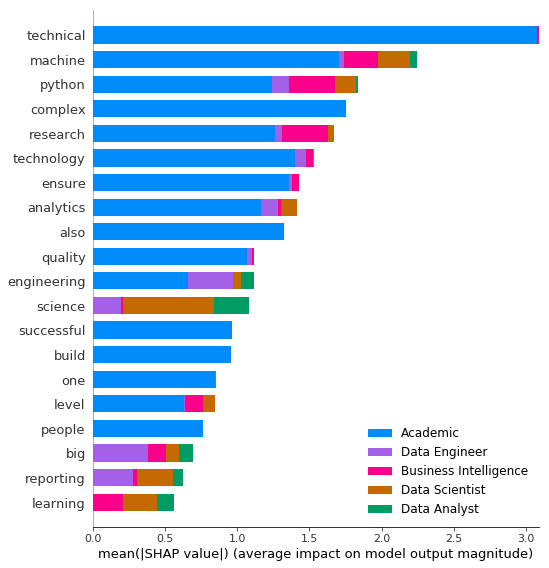

In [39]:
shap.summary_plot(shap_values,X_test_array,feature_names=vect.get_feature_names(),
                  class_names=['Academic','Business Intelligence','Data Analyst','Data Engineer','Data Scientist'])